**Librerias**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.features import featureEngineering

**Cargar datos**

In [2]:
df =  pd.read_excel("../data/interim/REPORTE_RECORD_ESTUDIANTIL_ANONIMIZADO.xlsx")

**Eliminar columnas sobrantes**

In [3]:
columnsToDrop = ['FACULTAD', 'CARRERA', 'MATERIA', 'COD_GRUPO', 'GRUPO/PARALELO']

In [4]:
df.drop(columns=columnsToDrop, inplace=True)

**Incluir modulos de ingles dentro de los ciclos normales**

In [5]:
mapeo = {
    '2023 - 2024 ING2B': '2023 - 2024 CII',
    '2024 - 2025 ING1B': '2024 - 2025 CI',
    '2024 - 2025 ING2B': '2024 - 2025 CII',
    '2025 - 2026 ING1A': '2025 - 2026 CI',
    '2025 - 2026 ING1B': '2025 - 2026 CI',
    }

In [6]:
df['PERIODO']= df['PERIODO'].map(lambda x: mapeo.get(x, x))

**Feature engineering**

Agregación por Estudiante-Periodo

In [9]:
agg = (
    df.groupby(["ESTUDIANTE", "PERIODO"])
    .agg(
        PROM_PERIODO=("PROMEDIO", "mean"),
        ASIST_PROM=("ASISTENCIA", "mean"),
        TOTAL_MAT=("COD_MATERIA", "count"),
        REPROBADAS=("ESTADO", lambda x: (x == "REPROBADA").sum()),
        REPITENCIAS=("NO. VEZ", lambda x: (x >= 2).sum()),
        NIVEL=("NIVEL", lambda x: x.mode().iloc[0])
        )
        .reset_index()
        )

In [10]:
agg = featureEngineering(agg)

**Definir la variable objetivo**


Un estudiante está en riesgo si cumple ≥ N criterios de riesgo
- `RIESGO_DESERCION = 1` si el estudiante cumple al menos 3 criterios de riesgo
- `RIESGO_DESERCION = 0` sin riesgo de deserción

In [9]:
agg.describe()

,PROM_PERIODO,ASIST_PROM,TOTAL_MAT,REPROBADAS,REPITENCIAS,NIVEL,TASA_REPROB,TASA_APROB,INDX_REPIT,EFICIENCIA,REPROB_x_ASIST
count,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000
mean,7.300401,80.474633,5.450980,0.924020,0.268382,1.775735,0.220317,0.779683,0.075104,70.820428,53.095561
std,2.709745,27.955286,2.712398,1.897783,0.918938,0.897139,0.381295,0.381295,0.231999,36.148369,150.572948
min,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.260000,78.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.833333,0.000000,63.855903,0.000000
50%,8.331875,91.287500,7.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,86.125000,0.000000
75%,8.905714,97.666667,7.000000,1.000000,0.000000,2.000000,0.166667,1.000000,0.000000,97.297619,13.906250
max,9.933333,100.000000,11.000000,8.000000,7.000000,4.000000,1.000000,1.000000,1.000000,100.000000,700.000000


In [11]:
agg["RIESGO_SCORE"] = (
    (agg["PROP_REPROB"] >= 0.4).astype(int) +
    (agg["ASIST_PROM"] < 70).astype(int) +
    (agg["PROM_PERIODO"] < 7).astype(int) +
    (agg["REPITENCIAS"] > 2).astype(int) +
    (agg["NIVEL"] <= 3).astype(int)
)

agg["RIESGO_t"] = (agg["RIESGO_SCORE"] >= 3).astype(int)

In [12]:
agg = agg.sort_values(["PERIODO"])
agg["RIESGO_t1"] = agg.groupby("ESTUDIANTE")["RIESGO_t"].shift(-1)

La variable objetivo fue desplazada temporalmente al período académico siguiente (t+1), permitiendo entrenar modelos predictivos que utilizan únicamente información disponible en el período actual, evitando sesgos por fuga de información y simulando un escenario real de toma de decisiones.

In [13]:
train_dataset = agg.dropna(subset=["RIESGO_t1"]).copy()
train_dataset["RIESGO_t1"] = train_dataset["RIESGO_t1"].astype(int)
train_dataset["RIESGO_t1"].value_counts(normalize=True) * 100

RIESGO_t1
0    86.585366
1    13.414634
Name: proportion, dtype: float64

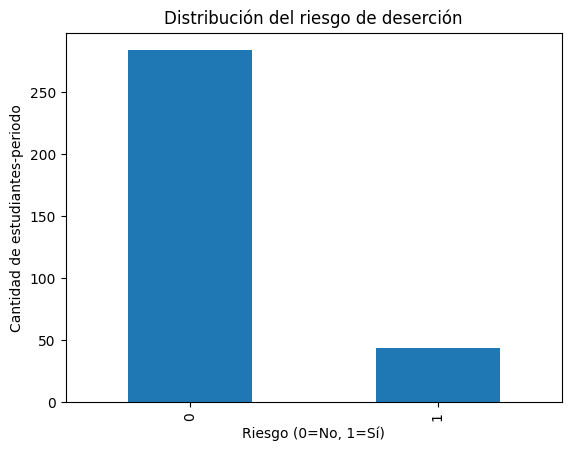

In [14]:
plt.figure()
train_dataset["RIESGO_t1"].value_counts().plot(kind="bar")
plt.title("Distribución del riesgo de deserción")
plt.xlabel("Riesgo (0=No, 1=Sí)")
plt.ylabel("Cantidad de estudiantes-periodo")
plt.show()

El conjunto de datos fue transformado a una estructura temporal estudiante–período, permitiendo definir una variable objetivo dinámica que representa el riesgo de deserción en el período siguiente, evitando el uso de información futura y garantizando consistencia temporal.

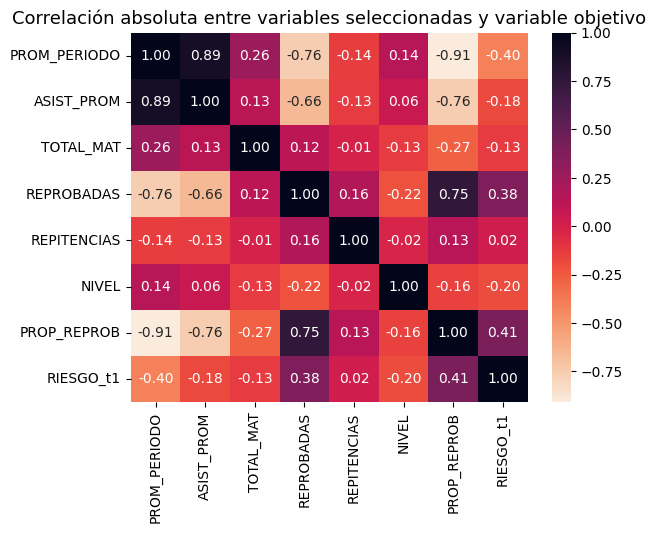

In [15]:
corr = agg[['PROM_PERIODO', 'ASIST_PROM', 'TOTAL_MAT',
           'REPROBADAS', 'REPITENCIAS', 'NIVEL',
           'PROP_REPROB','RIESGO_t1']].corr()
sns.heatmap(corr, cmap="rocket_r", annot=True, fmt=".2f")
plt.title("Correlación absoluta entre variables seleccionadas y variable objetivo", fontsize=13)
plt.show()

In [16]:
agg.to_excel("../data/processed/all_dataset.xlsx", index=False)

In [17]:
# Guardar datos listos para el entrenamiento del modelo
train_dataset.to_excel("../data/processed/train_dataset.xlsx", index=False)

In [ ]:
# Guardar datos para test cuando se tenga el proximo periodo
test_dataset = agg[agg["RIESGO_t1"].isna()]